# Toy Model J=0, J=1 with four F levels, J'=1
All with only mF=0
F'=0

In [184]:
import sys
sys.path.append("..")

import time
import pprint
import numpy as np
from tqdm import tqdm
import multiprocessing
from sympy import Symbol
import matplotlib.pyplot as plt
from utils.plot_utils import set_fontsize
from optical_bloch.utils.general import flatten
from optical_bloch import Hamiltonian, Dissipator, BlochEquations
from multi_helper_funcs import multi_solve_ode, multi_solve_ode_integrate_excited

In [185]:
E0_1 = Symbol(u'E0_1', real = True)
E0_0 = Symbol(u'E0_0', real = True)
E1_0 = Symbol(u'E1_0', real = True)
E1_1 = Symbol(u'E1_1', real = True)
E1_2 = Symbol(u'E1_2', real = True)
E1_3 = Symbol(u'E1_3', real = True)
Ee = Symbol(u'Ee', real = True)

ωl = Symbol(u'ωl', real = True)
Ωl = Symbol(u'Ωl', real = True)
ωμ = Symbol(u'ωμ', real = True)
Ωμ = Symbol(u'Ωμ', real = True)

δl = Symbol(u'δl', real = True)
δμ = Symbol(u'δμ', real = True)

a = Symbol('a', real = True)
b = Symbol('b', real = True)
c = Symbol('c', real = True)
d = Symbol('d', real = True)
α_0 = Symbol('α_0', real = True)
α_1 = Symbol('α_1', real = True)
α_2 = Symbol('α_2', real = True)
β_0 = Symbol('β_0', real = True)
β_1 = Symbol('β_1', real = True)
β_2 = Symbol('β_2', real = True)
β_3 = Symbol('β_3', real = True)

Δ0 = Symbol('Δ0', real = True)
Δ10 = Symbol('Δ10', real = True)
Δ11 = Symbol('Δ11', real = True)
Δ12 = Symbol('Δ12', real = True)

Toy model with a single J=0 state coupled via microwaves to J=1 with 2 sublevels, and J=1 is coupled with a laser to J'=1, assuming only mF=0 levels

In [186]:
from sympy import sin, Symbol, conjugate, linear_eq_to_matrix

In [187]:
ham = Hamiltonian(7)
ham.addEnergies([E0_1, E0_0, E1_0, E1_1, E1_2, E1_3, Ee])
ham.addCoupling(2,6,a*Ωl, ωl)
ham.addCoupling(3,6,b*Ωl, ωl)
ham.addCoupling(4,6,c*Ωl, ωl)
ham.addCoupling(5,6,d*Ωl, ωl)
ham.addCoupling(0,2,β_0*Ωμ, ωμ)
ham.addCoupling(0,3,β_1*Ωμ, ωμ)
ham.addCoupling(0,4,β_2*Ωμ, ωμ)
ham.addCoupling(0,5,β_3*Ωμ, ωμ)
ham.addCoupling(1,2,α_0*Ωμ, ωμ)
ham.addCoupling(1,3,α_1*Ωμ, ωμ)
ham.addCoupling(1,4,α_2*Ωμ, ωμ)

ham.eqnTransform()
ham.defineZero(Ee)
ham.defineStateDetuning(2,6,δl)
ham.defineStateDetuning(3,6,δl)
ham.defineStateDetuning(4,6,δl)
ham.defineStateDetuning(5,6,δl)

ham.defineStateDetuning(0,2,δμ)
ham.defineStateDetuning(0,3,δμ)
ham.defineStateDetuning(0,4,δμ)
ham.defineStateDetuning(0,5,δμ)

ham.defineStateDetuning(1,2,δμ)
ham.defineStateDetuning(1,3,δμ)
ham.defineStateDetuning(1,4,δμ)

In [188]:
Γ63 = Symbol(u'Γ63', real = True)
Γ64 = Symbol(u'Γ64', real = True)
dis = Dissipator(ham.levels)
dis.addDecay(6,3,Γ63)
dis.addDecay(6,4,Γ64)

In [189]:
from sympy import nsimplify

In [190]:
ham.transformed = nsimplify(ham.transformed)
ham.transformed = ham.transformed.subs(E0_0-E0_1, Δ0)
ham.transformed = ham.transformed.subs(E1_0-E1_1, Δ10)
ham.transformed = ham.transformed.subs(E1_0-E1_2, Δ10 + Δ11)
ham.transformed = ham.transformed.subs(E1_0-E1_3, Δ10 + Δ11 + Δ12)
ham.transformed

Matrix([
[ -δl - δμ,            0, -Ωμ*β_0/2, -Ωμ*β_1/2,       -Ωμ*β_2/2,             -Ωμ*β_3/2,       0],
[        0, Δ0 - δl - δμ, -Ωμ*α_0/2, -Ωμ*α_1/2,       -Ωμ*α_2/2,                     0,       0],
[-Ωμ*β_0/2,    -Ωμ*α_0/2,       -δl,         0,               0,                     0, -a*Ωl/2],
[-Ωμ*β_1/2,    -Ωμ*α_1/2,         0, -Δ10 - δl,               0,                     0, -b*Ωl/2],
[-Ωμ*β_2/2,    -Ωμ*α_2/2,         0,         0, -Δ10 - Δ11 - δl,                     0, -c*Ωl/2],
[-Ωμ*β_3/2,            0,         0,         0,               0, -Δ10 - Δ11 - Δ12 - δl, -d*Ωl/2],
[        0,            0,   -a*Ωl/2,   -b*Ωl/2,         -c*Ωl/2,               -d*Ωl/2,       0]])

In [191]:
dis.dissipator

Matrix([
[                               0,                                0,                                0,                                0,                                0,                                0, -(Γ63 + Γ64)*ρ₀₆(t)/2],
[                               0,                                0,                                0,                                0,                                0,                                0, -(Γ63 + Γ64)*ρ₁₆(t)/2],
[                               0,                                0,                                0,                                0,                                0,                                0, -(Γ63 + Γ64)*ρ₂₆(t)/2],
[                               0,                                0,                                0,                       Γ63*ρ₆₆(t),                                0,                                0, -(Γ63 + Γ64)*ρ₃₆(t)/2],
[                               0,                                0,       

In [192]:
bloch = BlochEquations(ham.levels, dis.density_matrix, ham.transformed, dis.dissipator)

In [193]:
y0 = np.zeros([bloch.levels, bloch.levels], dtype = complex)
y0[2,2] = 1/4
y0[3,3] = 1/4
y0[4,4] = 1/4
y0[5,5] = 1/4
y0 = y0.flatten()

In [194]:
replacements = [(δl, 0),
                (δμ, 0),
                (a, 0),
                (b, 0.6323231299412123),
                (c, 0.3676768700587878),
                (d, 0),
                (α_0, 0),
                (α_1, 1),
                (α_2, 1),
                (β_0, 1),
                (β_1, 1),
                (β_2, 1),
                (β_3, 1),
                (Ωl, 1),
                (Ωμ, 1),
                (Δ0, 0.0083125),
                (Δ10, 0.0090625),
                (Δ11, 0.11),
                (Δ12, 0.013875),
                (Γ63, 1),
                (Γ64, 0.5)]

In [195]:
%%time
sol = bloch.solveNumeric(replacements, [0,300], y0, method = 'BDF')

Wall time: 4.36 s


1.9926050615915059

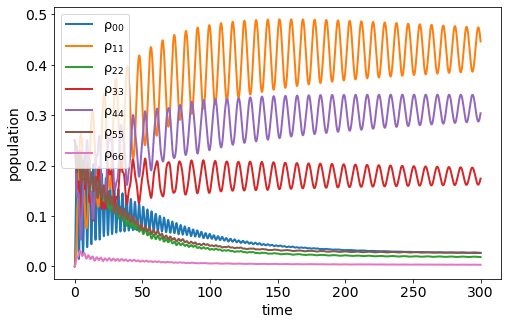

In [196]:
r = np.einsum("iij->ij", sol.y.reshape(ham.levels, ham.levels,sol.t.size)).real

fig, ax = plt.subplots(figsize = (8,5))
for idx in range(ham.levels):
    ax.plot(sol.t, r[idx], label = f'ρ$_{{{idx}{idx}}}$', lw = 2)

ax.legend(fontsize = 13)
ax.set_xlabel('time')
ax.set_ylabel('population')

set_fontsize(ax, 14)

np.trapz(np.sum(sol.y[[-1]].real, axis = 0), sol.t)

In [95]:
from julia import Main

In [96]:
nprocs = 12 # number of processes to use for EnsembleDistributed
Main.eval(f"""
using BenchmarkTools
using Distributed
""")

if Main.eval("nprocs()") < nprocs:
    Main.eval(f"addprocs({nprocs}-nprocs())")

if Main.eval("nprocs()") > nprocs:
    addprocs({nprocs})
    procs = Main.eval("procs()")
    procs = procs[nprocs:]
    Main.eval(f"rmprocs({procs})")

Main.eval("""
@everywhere begin
    using ModelingToolkit
    using LinearAlgebra
    using Trapz
    using DifferentialEquations
end
""")

    
Main.eval("procs()")

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [102]:
from sympy import MutableDenseMatrix, conjugate, Function, Symbol

t = Symbol('t', real = True)

hamiltonian_symbols = ham.transformed.free_symbols
dissipator_symbols = dis.dissipator.free_symbols
dissipator_symbols = set([d for d in dissipator_symbols if str(d)[0] not in ['ρ', 't']])

for s in list(hamiltonian_symbols) + list(dissipator_symbols):
    Main.eval(f"""
                @everywhere @parameters {str(s)}
                tmp = 0
            """);


lx, ly = ham.transformed.shape
Main.eval(f"""
            @everywhere begin
                H = zeros(Num, {lx}, {ly})
                L = zeros(Num, {lx}, {ly})
                @variables t ρ[1:{lx},1:{ly}](t)
                @parameters icomplex
                D = Differential(t)
                tmp = 0
            end
            """);

# the code below is to transform the symbolic version of Sympy into a form usable with Julia
diss = MutableDenseMatrix(dis.dissipator.copy())

for i in range(lx):
    for j in range(i,ly):
        tmp = Function(u'ρ{0}{1}'.format(chr(0x2080+i), 
                                         chr(0x2080+j)))
        tmp1 = Function(u'ρ[{0},{1}]'.format(j+1, i+1))
        diss = diss.subs(conjugate(tmp(t)), tmp1(t))
            
for i in range(lx):
    for j in range(i,ly):
        tmp = Function(u'ρ{0}{1}'.format(chr(0x2080+i), 
                                         chr(0x2080+j)))
        tmp1 = Function(u'ρ[{0},{1}]'.format(i+1, j+1))
        diss = diss.subs(tmp(t), tmp1(t))


# Creating the Hamiltonian matrix and Dissipator matrix in Julia
for idx in range(1,lx+1):
    for idy in range(1,ly+1):
        hval = str(ham.transformed[idx-1,idy-1])
        dval = str(diss[idx-1, idy-1])
        dval = dval.replace('(t)', '')
        Main.eval(f"""
                @everywhere begin
                    H[{idx},{idy}] = {hval}
                    L[{idx},{idy}] = {dval}
                    tmp = 0
                end
                """);
        
# ham_pars = ham.transformed.free_symbols

In [103]:
# Creating the system of equations
ham_string = ','.join([str(h) for h in hamiltonian_symbols])
diss_string = ','.join([str(d) for d in dissipator_symbols])

Main.eval(f"""
@everywhere begin
    eq = -icomplex*Symbolics.scalarize(H*ρ-ρ*H) + L
    eqns = [D(ρ[idx,idy]) ~ eq[idx,idy] for idx in 1:{lx} for idy in 1:{ly}];
    bloch = ODESystem(eqns)

    tmp = 0
end
""");

In [106]:
# initial populations
y0 = np.zeros([ham.levels, ham.levels], dtype = complex)
for _ in range(2,6):
    y0[_,_] = 1/4
Main.ρ_ini = y0
Main.eval("@everywhere ρ_ini = $ρ_ini")

In [109]:
# setting up the parameters of the model and initial conditions
# value ratios taken from real TlF hamiltonian
Main.eval("""
    @everywhere begin
    p = [
        δl => 0,
        δμ => 0,
        a => 0,
        b => 0.6323231299412123,
        c => 0.3676768700587878,
        d => 0,
        α_0 => 0,
        α_1 => 1,
        α_2 => 1,
        β_0 => 1,
        β_1 => 1,
        β_2 => 1,
        β_3 => 1,
        Ωl => 1,
        Ωμ => 1,
        Δ0 => 0.0083125,
        Δ10 => 0.0090625,
        Δ11 => 0.11,
        Δ12 => 0.013875,
        Γ63 => 1,
        Γ64 => 0.5,
        icomplex => im
    ]
    u0 = [ρ[idx,idy] => ρ_ini[idx,idy] for idx in 1:size(ρ_ini)[1] for idy in 1:size(ρ_ini)[1]]
    tmp =0;
end
""");

In [110]:
# creating the problem to solve
Main.eval("""
@everywhere begin
    tspan = (0.0, 300.)
    prob = ODEProblem(bloch, ρ_ini, tspan, p, jac = true)
end
""");

In [132]:
# solving the ODEProblem, keep in mind that the first run compiles called functions
# the first run will be significantly slower (due to compilation), but any subsequent solves are fast
Main.eval("@time sol = solve(prob, Tsit5(), abstol = 1e-10, reltol = 1e-10)");

In [133]:
ut = np.array(Main.eval("sol[:]"))
dim = int(np.sqrt(ut.shape[1]))
pop_results = np.real(np.einsum('jji->ji',ut.reshape(-1,dim, dim).T))
t_array = Main.eval("sol.t") 

4.173749496557058

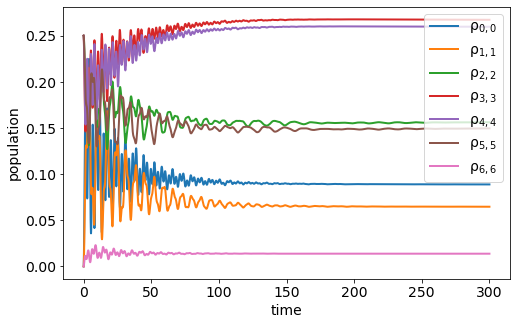

In [150]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$")

ax.set_xlabel('time')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

np.trapz(np.sum(pop_results[[-1],:].real, axis = 0), t_array)

## Ensemble Problems
Scanning $\Omega_l$ and $\Omega_\mu$

In [167]:
# function that specifies what to do which each solution of the Ensemble
# in this case integrating over the excited state
# you could return the entire solution but for larger systems with many parameter scans
# this consumes a lot of memory
Main.eval("""
@everywhere function output_func(sol,i)
           return trapz(sol.t, [real(sol.u[j][end]) for j in 1:size(sol.u)[1]]), false
       end
""")

In [168]:
# this function remakes the problem to change the parameters
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    pnew = ModelingToolkit.varmap_to_vars([
        δl => 0,
        δμ => 0,
        a => 0,
        b => 0.6323231299412123,
        c => 0.3676768700587878,
        d => 0,
        α_0 => 0,
        α_1 => 1,
        α_2 => 1,
        β_0 => 1,
        β_1 => 1,
        β_2 => 1,
        β_3 => 1,
        Ωl => params[i,1],
        Ωμ => params[i,2],
        Δ0 => 0.0083125,
        Δ10 => 0.0090625,
        Δ11 => 0.11,
        Δ12 => 0.013875,
        Γ63 => 1,
        Γ64 => 0.5,
        icomplex => im
        ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

In [169]:
# creating the parameter space to scan
Ωls = np.linspace(0,20,101)
Ωμs = np.linspace(0,20,101)
params = np.array(np.meshgrid(Ωls, Ωμs)).T.reshape(-1,2)
Main.params = params
Main.eval("@everywhere params = $params")

In [170]:
# creating the EnsembleProblem
# prob_func specifies a function that changes the problem to solve for each iteration
# output_func specifies a function that takes the solution for each iteration and perfoms
# some calculation, which subsequently is returned as the solution for that iteration
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [171]:
# solve the EnsembleProblem
# EnsembleDistributed() is the parallel solver method. See DifferentialEquations.jl for more options.
Main.eval("""
sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), trajectories = size(params)[1],
            abstol = 1e-9, reltol = 1e-6)
sim.elapsedTime
""")

342.7736285

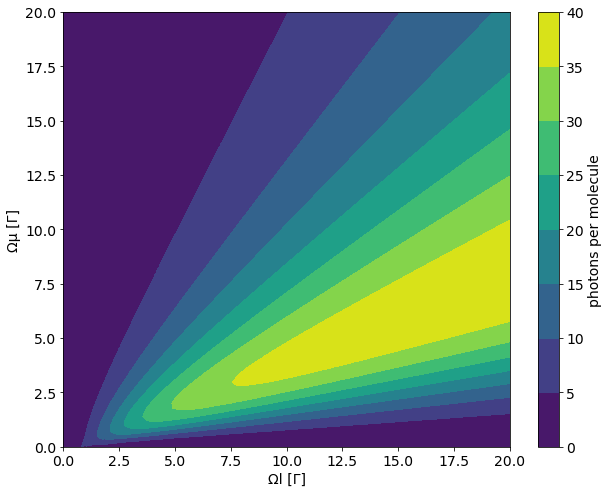

In [172]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0], params[:,1], np.array(Main.eval("sim.u")))

cbar = fig.colorbar(tcf)

ax.set_xlabel('Ωl [Γ]')
ax.set_ylabel(r'Ωμ [Γ]')
cbar.ax.set_ylabel('photons per molecule')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

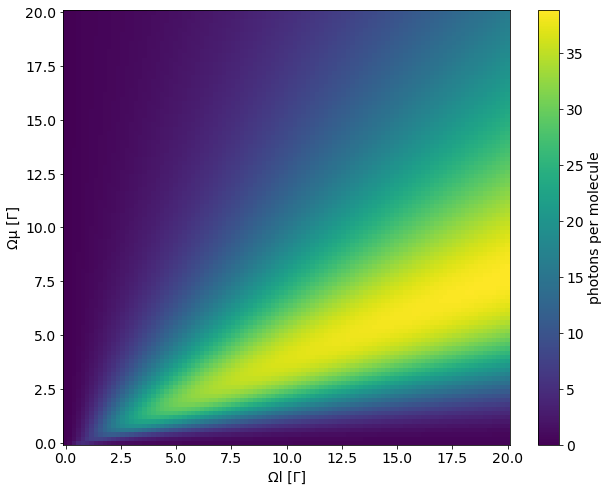

In [173]:
X, Y = np.meshgrid(np.unique(params[:,0]), np.unique(params[:,1]))

fig, ax = plt.subplots(figsize = (10,8))

c = ax.pcolormesh(X, Y, np.array(Main.eval("sim.u")).reshape(-1,X.shape[1]).T, shading="auto")
cbar = fig.colorbar(c)

ax.set_xlabel('Ωl [Γ]')
ax.set_ylabel('Ωμ [Γ]')
cbar.ax.set_ylabel('photons per molecule')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

## Ensemble Problem Scan microwave detuning and microwave power

In [174]:
Δμs = np.linspace(-10,10,101)
Ωμs = np.linspace(0,20,101)
params = np.array(np.meshgrid(Δμs, Ωμs)).T.reshape(-1,2)
Main.params = params
Main.eval("@everywhere params = $params")

In [175]:
# this function remakes the problem to change the parameters
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    pnew = ModelingToolkit.varmap_to_vars([
        δl => 0,
        δμ => params[i,1],
        a => 0,
        b => 0.6323231299412123,
        c => 0.3676768700587878,
        d => 0,
        α_0 => 0,
        α_1 => 1,
        α_2 => 1,
        β_0 => 1,
        β_1 => 1,
        β_2 => 1,
        β_3 => 1,
        Ωl => 10,
        Ωμ => params[i,2],
        Δ0 => 0.0083125,
        Δ10 => 0.0090625,
        Δ11 => 0.11,
        Δ12 => 0.013875,
        Γ63 => 1,
        Γ64 => 0.5,
        icomplex => im
        ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

In [176]:
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [177]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), trajectories = size(params)[1], 
                   abstol = 1e-9, reltol = 1e-6)
sim.elapsedTime
""")

284.6083092

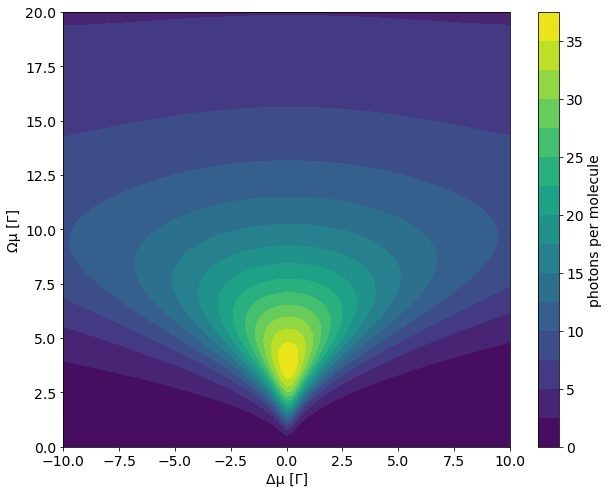

In [178]:
fig, ax = plt.subplots(figsize= (10,8))

tcf = ax.tricontourf(params[:,0], params[:,1], np.array(Main.eval("sim.u")), levels = 15)

cbar = fig.colorbar(tcf)

ax.set_xlabel('Δμ [Γ]')
ax.set_ylabel(r'Ωμ [Γ]')
cbar.ax.set_ylabel('photons per molecule')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)